# Model Development 

In [110]:
#Import basic packages
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
file = '//Users//chung-tsengwang//Desktop//Github Repo//Census-Income-with-Tree-Based-Models//data//processed//processed.csv'
#file = 'C:\\Users\\Chung-Tseng Wang\\Desktop\\Census-Income-with-Tree-Based-Models\\data\\processed\\processed.csv'
adult = pd.read_csv(file)
adult = adult.drop(['Unnamed: 0'], axis = 1)
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [112]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capitalgain       48842 non-null int64
capitalloss       48842 non-null int64
hoursperweek      48842 non-null int64
native-country    48842 non-null object
class             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [113]:
#Seperating target variable from the rest of the features
adult_data = adult.drop(columns = ['class'])
adult_label = adult['class']

In [114]:
#Binarize target label
from sklearn.preprocessing import LabelBinarizer 
Binarizer = LabelBinarizer()
adult_label = Binarizer.fit_transform(adult_label)

In [115]:
#Converting all categorical features into dummy variables
adult_cat = pd.get_dummies(adult_data.select_dtypes('object'))
adult_noncat = adult_data.select_dtypes(exclude = 'object')

adult_data = pd.concat([adult_noncat, adult_cat], axis = 1, join = 'inner')

In [116]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(adult_data, adult_label, test_size = 0.3, random_state = 21)

In [117]:
#Standard Scaler 
#from sklearn.preprocessing import StandardScaler 
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)

In [118]:
#Model Evaluation Function 
from sklearn.metrics import confusion_matrix
def model_eval(true, pred):
    #Confusion Matrix 
    true = true.reshape(len(true),)
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    #Output 
    output = {}
    output['accuracy'] = ((tp+tn))/(tp+fn+fp+tn)
    output['precision'] = (tp)/(tp+fp)
    output['recall'] = (tp)/(tp+fn)
    output['f_measure'] = (2*output['recall']*output['precision'])/(output['recall']+output['precision'])
    output['sensitivity'] = tp / (tp + fn)
    output['specificity'] = tn / (tn + fp)
    output['error_rate'] = 1 - output['accuracy']
    
    return output

## Building Decision Tree

In [136]:
#Training Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
tree_clf_1 = DecisionTreeClassifier(max_depth = 2)
tree_clf_1.fit(X_train, y_train)
tree_clf_1_pred = tree_clf_1.predict(X_test)
tree1_res = model_eval(y_test, tree_clf_1_pred)
tree1_res

{'accuracy': 0.8261789394663209,
 'precision': 0.7328280435812411,
 'recall': 0.4382436260623229,
 'f_measure': 0.5484843112923239,
 'sensitivity': 0.4382436260623229,
 'specificity': 0.9492942551469927,
 'error_rate': 0.17382106053367907}

In [120]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
import graphviz
from sklearn import tree
from graphviz import Source

graph = Source( tree.export_graphviz(tree_clf, out_file = None,
                                     feature_names = adult_data.columns,
                                     class_names = adult['class'].unique()))

#Save Tree as PNG
png_bytes = graph.pipe(format='png')
with open('initial_tree.png','wb') as f:
    f.write(png_bytes)

### Hypterparameter tuning 

#### 1. Max depth - Graph ROC AUC results of 20 depths

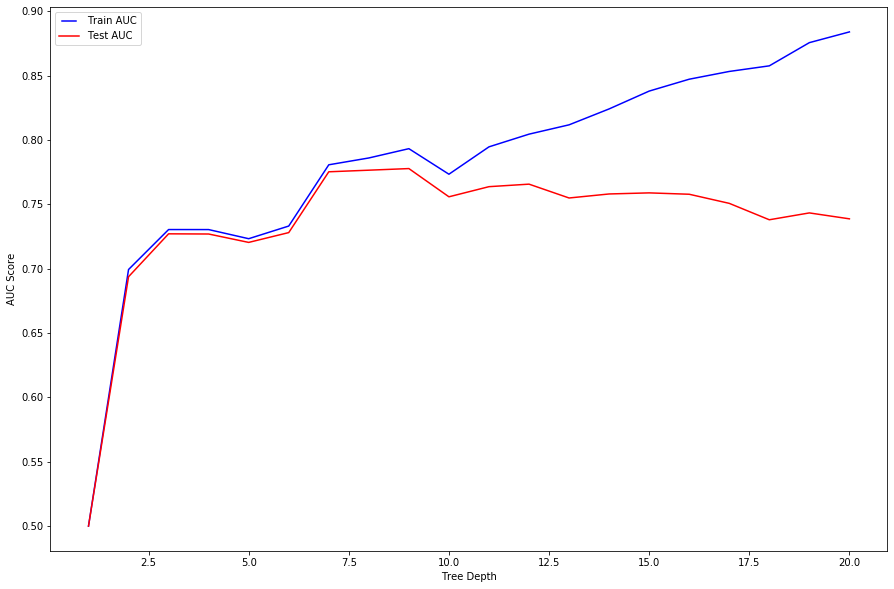

In [121]:
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

#Tree Depth vector
max_depth = np.linspace(1,20,20)

#initiate result list 
train_res = []
test_res = []

#Loop through max_depth and calculate AUC of ROC curve and then graph it 
for n in max_depth:
    dt = DecisionTreeClassifier(max_depth = n)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    
    fpr, tpr, t = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_res.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    
    fpr, tpr, t = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_res.append(roc_auc)
    
f, ax = plt.subplots(figsize=(15, 10))
train_line, = plt.plot(max_depth, train_res, 'b', label = 'Train AUC')
test_line, = plt.plot(max_depth, test_res, 'r', label = 'Test AUC')
plt.legend(handler_map={train_line: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


In [122]:
#Training Decision Tree Classifier
tree_clf_2 = DecisionTreeClassifier(max_depth = 9)
tree_clf_2.fit(X_train, y_train)
tree_clf_2_pred = tree_clf_2.predict(X_test)

In [123]:
#Model Evaluation 
tree2_res = model_eval(y_test, tree_clf_2_pred)
tree2_res

{'accuracy': 0.8435132737323415,
 'precision': 0.6841321821970825,
 'recall': 0.6509915014164306,
 'f_measure': 0.667150529830164,
 'sensitivity': 0.6509915014164306,
 'specificity': 0.9046120650903533,
 'error_rate': 0.15648672626765847}

#### 2. min_samples_split - Graph ROC AUC for 10 splits

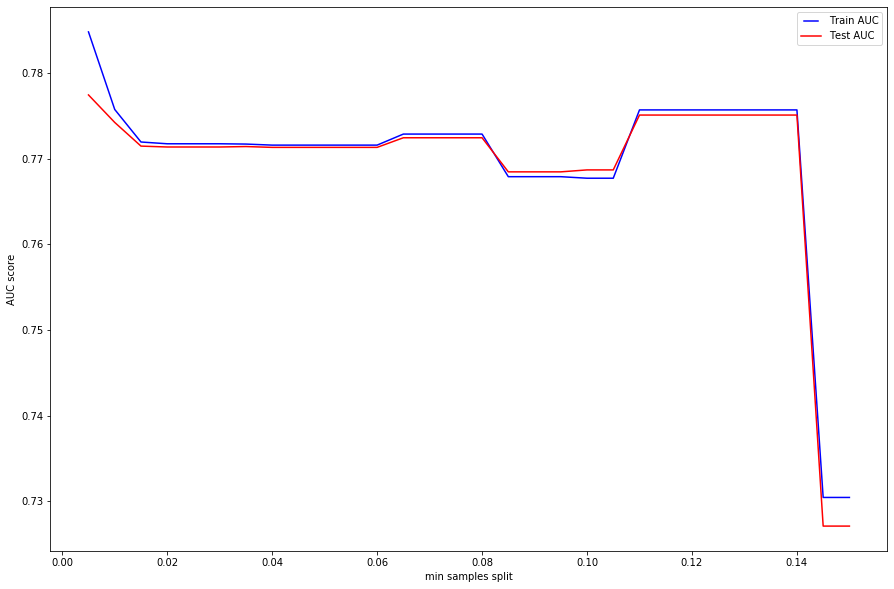

In [144]:
min_samples_splits = np.linspace(.005,0.15, 30, endpoint=True)
train_res = []
test_res = []
for n in min_samples_splits:
    dt = DecisionTreeClassifier(max_depth = 9, min_samples_split=n)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    
    fpr, tpr, t = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_res.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    fpr, tpr, t = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_res.append(roc_auc)

f, ax = plt.subplots(figsize=(15, 10))
train_line, = plt.plot(min_samples_splits, train_res, 'b', label='Train AUC')
test_line, = plt.plot(min_samples_splits, test_res, 'r', label='Test AUC')
plt.legend(handler_map={train_line: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [148]:
tree_clf_3 = DecisionTreeClassifier(max_depth = 9, min_samples_split = 0.05)
tree_clf_3.fit(X_train, y_train)
tree_clf_3_pred = tree_clf_3.predict(X_test)
tree3_res = model_eval(y_test, tree_clf_3_pred)
tree3_res

{'accuracy': 0.8451511635842489,
 'precision': 0.6983328090594526,
 'recall': 0.6288951841359773,
 'f_measure': 0.6617975853331345,
 'sensitivity': 0.6288951841359773,
 'specificity': 0.9137822529893015,
 'error_rate': 0.1548488364157511}

#### 3. Min_samples_leaf - Graph ROC AUC for 10 splits


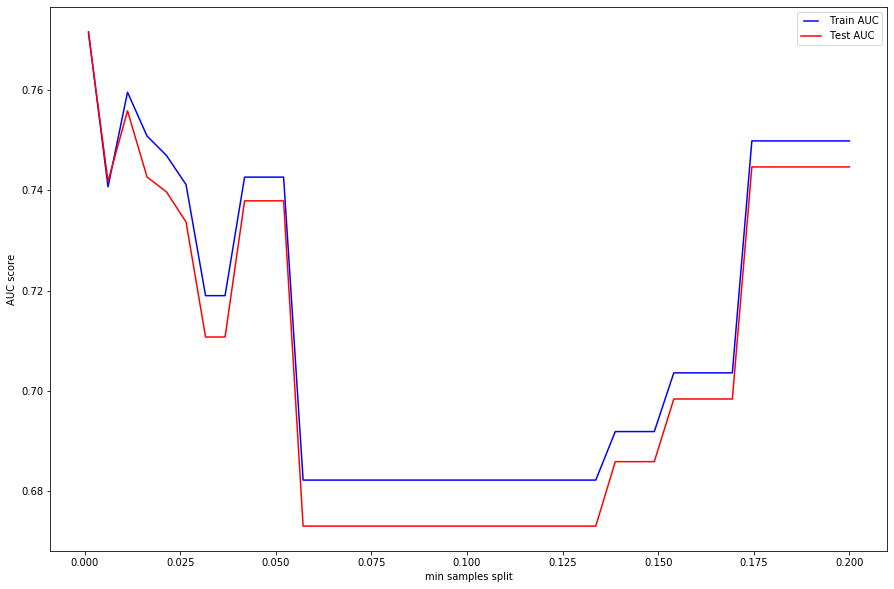

In [150]:
min_samples_leaf = np.linspace(0.001, 0.2, 40)
train_res = []
test_res = []
for n in min_samples_leaf:
    dt = DecisionTreeClassifier(max_depth = 9, min_samples_split = 0.05, min_samples_leaf = n)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    
    fpr, tpr, t = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_res.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    fpr, tpr, t = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_res.append(roc_auc)

f, ax = plt.subplots(figsize=(15, 10))
train_line, = plt.plot(min_samples_leaf, train_res, 'b', label='Train AUC')
test_line, = plt.plot(min_samples_leaf, test_res, 'r', label='Test AUC')
plt.legend(handler_map={train_line: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [151]:
tree_clf_4 = DecisionTreeClassifier(max_depth = 9, min_samples_split = 0.05, min_samples_leaf = 0.001)
tree_clf_4.fit(X_train, y_train)
tree_clf_4_pred = tree_clf_4.predict(X_test)
tree4_res = model_eval(y_test, tree_clf_4_pred)
tree4_res

{'accuracy': 0.8451511635842489,
 'precision': 0.6983328090594526,
 'recall': 0.6288951841359773,
 'f_measure': 0.6617975853331345,
 'sensitivity': 0.6288951841359773,
 'specificity': 0.9137822529893015,
 'error_rate': 0.1548488364157511}

#### 4. Max_features- Comparing auto, sqrt, log2, and None

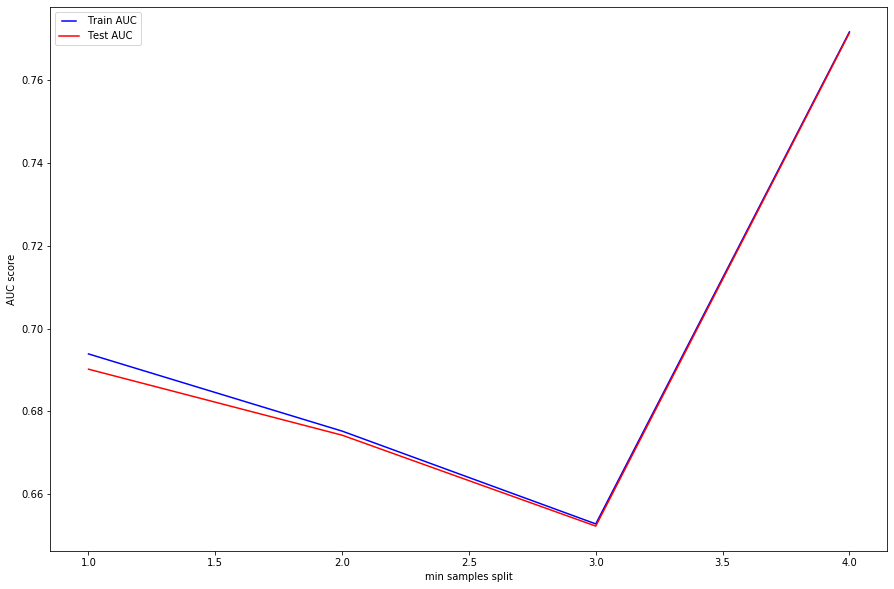

In [155]:
features = ['auto','sqrt','log2',None]
train_res = []
test_res = []
for n in features:
    dt = DecisionTreeClassifier(max_depth = 9, min_samples_split = 0.05, min_samples_leaf = .001, max_features = n)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    
    fpr, tpr, t = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_res.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    fpr, tpr, t = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_res.append(roc_auc)

f, ax = plt.subplots(figsize=(15, 10))
train_line, = plt.plot(np.linspace(1, 4, 4), train_res, 'b', label='Train AUC')
test_line, = plt.plot(np.linspace(1, 4, 4), test_res, 'r', label='Test AUC')
plt.legend(handler_map={train_line: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [156]:
overall_model = round(pd.DataFrame([tree1_res, tree2_res,tree3_res, tree4_res], index = ['Tree 1','Tree 2', 'Tree 3', 'Tree 4']),4)
overall_model

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
Tree 1,0.8262,0.7328,0.4382,0.5485,0.4382,0.9493,0.1738
Tree 2,0.8435,0.6841,0.6510,0.6672,0.6510,0.9046,0.1565
Tree 3,0.8452,0.6983,0.6289,0.6618,0.6289,0.9138,0.1548
Tree 4,0.8452,0.6983,0.6289,0.6618,0.6289,0.9138,0.1548


In [157]:
graph = Source( tree.export_graphviz(tree_clf_4, out_file = None,
                                     feature_names = adult_data.columns,
                                     class_names = adult['class'].unique()))

#Save Tree as PNG
png_bytes = graph.pipe(format='png')
with open('Tuned_tree.png','wb') as f:
    f.write(png_bytes)

## Building Random Forest

In [165]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 21)
forest_clf.fit(X_train, y_train)
forest1_pred = forest_clf.predict(X_test)

/Users/chung-tsengwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/chung-tsengwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [169]:
forest_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 21,
 'verbose': 0,
 'warm_start': False}

In [167]:
model_eval(y_test, forest1_pred)

{'accuracy': 0.8336176892104006,
 'precision': 0.686858316221766,
 'recall': 0.5685552407932011,
 'f_measure': 0.6221326720396776,
 'sensitivity': 0.5685552407932011,
 'specificity': 0.9177380203182595,
 'error_rate': 0.16638231078959942}

### Hyperparameter Tuning 
Parameters to tune: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features

We will use RandomizedSearchCV to find the best combination of all the hyperparameters

In [176]:
#Setting up list of features to test
n_estimators = [int(x) for x in np.linspace(10,500,50)]
max_features = ['auto','sqrt','log2', None]
max_depth = [int(x) for x in np.linspace(1,50,50)]
max_depth.append(None)
min_samples_split = np.linspace(0.01, 0.2, 20)
min_samples_leaf = np.linspace(0.01, 0.2, 20)
bootstrap = [True, False]

#Create Random Grid 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, None], 'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]), 'min_samples_leaf': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]), 'bootstrap': [True, False]}


In [178]:
from sklearn.model_selection import RandomizedSearchCV

#Random search of parameters, using 3 fold CV, and 200 iterations
rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                          n_iter = 200, cv = 3, verbose = 2, random_state = 42, n_jobs = -1
                          )
rf_rs.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 20.1min finished
/Users/chung-tsengwang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [180]:
rf_rs.best_params_

{'n_estimators': 200,
 'min_samples_split': 0.03,
 'min_samples_leaf': 0.01,
 'max_features': None,
 'max_depth': 36,
 'bootstrap': False}

In [183]:
#Evalusate Random Search
forest_clf = RandomForestClassifier(n_estimators = 200,
                                    min_samples_split = 0.03,
                                    min_samples_leaf = 0.01,
                                    max_features = None,
                                    max_depth = 36,
                                    bootstrap = False,
                                    random_state = 21)
forest_clf.fit(X_train, y_train)
forest2_pred = forest_clf.predict(X_test)

/Users/chung-tsengwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [184]:
model_eval(y_test, forest2_pred)

{'accuracy': 0.8387360949976114,
 'precision': 0.7007223942208463,
 'recall': 0.5770538243626062,
 'f_measure': 0.6329035264874942,
 'sensitivity': 0.5770538243626062,
 'specificity': 0.9217836914501484,
 'error_rate': 0.16126390500238863}

Use GridSearch CV to narrow the search